In [2]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#압축풀기
import zipfile

local_zip = '/content/drive/MyDrive/데이터저장/human or animal2.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/manwomandetection')
zip_ref.close()

# 경로지정하기

In [5]:
#기본경로
base_dir='/content/manwomandetection'

train_dir=os.path.join(base_dir,'train')
val_dir=os.path.join(base_dir,'val')
test_dir=os.path.join(base_dir,'test')

In [6]:
#훈련 이미지 경로
train_human_dir=os.path.join(train_dir,'human')
train_animal_dir=os.path.join(train_dir,'animal')

#validation 이미지 경로
val_human_dir=os.path.join(val_dir,'human')
val_animal_dir=os.path.join(val_dir,'animal')

#test 이미지 경로
# test_human_dir=os.path.join(test_dir,'human')
# test_animal_dir=os.path.join(test_dir,'animal')

In [7]:
#리스트에 담기
#train
train_human_fnames=os.listdir(train_human_dir)
train_animal_fnames=os.listdir(train_animal_dir)
print(train_human_fnames[:5])
print(train_animal_fnames[:5])

#validation
val_human_fnames=os.listdir(val_human_dir)
val_animal_fnames=os.listdir(val_animal_dir)
#print(val_animal_fnames[:5])

#test
# test_human_fnames=os.listdir(test_human_dir)
# test_animal_fnames=os.listdir(test_animal_dir)
# print(test_human_fnames[:5])

['human (25322).jpg', 'human (44811).jpg', 'human (11816).jpg', 'human (6074).jpg', 'human (46376).jpg']
['pixabay_cat_000444.jpg', 'flickr_wild_002221.jpg', 'pixabay_cat_003025.jpg', 'flickr_dog_000238.jpg', 'pixabay_wild_000770.jpg']


In [8]:
#각 데이터 개수 확인하기
print('train human {}'.format(len(train_human_fnames)))
print('train animal {}'.format(len(train_animal_fnames)))

print('val human {}'.format(len(val_human_fnames)))
print('val animal {}'.format(len(val_animal_fnames)))

train human 48624
train animal 14630
val human 11995
val animal 1500


# 데이터셋/전처리

In [9]:
batch=32
img_height=250
img_width=250

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  zoom_range=0.3
                                  )
val_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  batch_size=batch,
                                                  class_mode='binary',
                                                  target_size=(img_width,img_height)
                                                  )
val_generator=val_datagen.flow_from_directory(val_dir,
                                              batch_size=batch,
                                              class_mode='binary',
                                              target_size=(img_width,img_height)
                                              )


Found 63254 images belonging to 2 classes.
Found 13495 images belonging to 2 classes.


In [11]:
print(train_generator.class_indices.items())

print(val_generator.class_indices.items())

dict_items([('animal', 0), ('human', 1)])
dict_items([('animal', 0), ('human', 1)])


# 모델만들기

In [12]:
import tensorflow as tf

tf.__version__

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [13]:
kernel_s=(3,3)

model=models.Sequential()

model.add(layers.Conv2D(32,kernel_s,activation='relu',input_shape=(img_height,img_width,3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 64)       0

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy'
              )

# 학습하기

In [15]:
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

earlystopping=EarlyStopping(monitor='val_loss', #val_loss 값이 개선되었을 때
                            patience=5 #5회 epoch 동안 val_loss가 개선되지 않는다면 종료
                            )

In [16]:
history=model.fit(train_generator,
                  steps_per_epoch=70,
                  epochs=10,
                  validation_data=val_generator,
                  validation_steps=50,
                  callbacks=[earlystopping]
                  )

Epoch 1/10
70/70 [==============================] - 42s 489ms/step - loss: 0.3161 - accuracy: 0.8871 - val_loss: 0.0430 - val_accuracy: 0.9837
Epoch 2/10
70/70 [==============================] - 34s 486ms/step - loss: 0.0798 - accuracy: 0.9723 - val_loss: 0.0273 - val_accuracy: 0.9931
Epoch 3/10
70/70 [==============================] - 34s 486ms/step - loss: 0.0873 - accuracy: 0.9710 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 4/10
70/70 [==============================] - 34s 485ms/step - loss: 0.0800 - accuracy: 0.9746 - val_loss: 0.1144 - val_accuracy: 0.9556
Epoch 5/10
70/70 [==============================] - 34s 486ms/step - loss: 0.0782 - accuracy: 0.9768 - val_loss: 0.0254 - val_accuracy: 0.9937
Epoch 6/10
70/70 [==============================] - 34s 488ms/step - loss: 0.0900 - accuracy: 0.9768 - val_loss: 0.0918 - val_accuracy: 0.9912
Epoch 7/10
70/70 [==============================] - 34s 480ms/step - loss: 0.0665 - accuracy: 0.9808 - val_loss: 0.0314 - val_accuracy: 0.9881

In [22]:
#모델 저장하기
from keras.models import load_model
model.save('인간동물분류.h5')

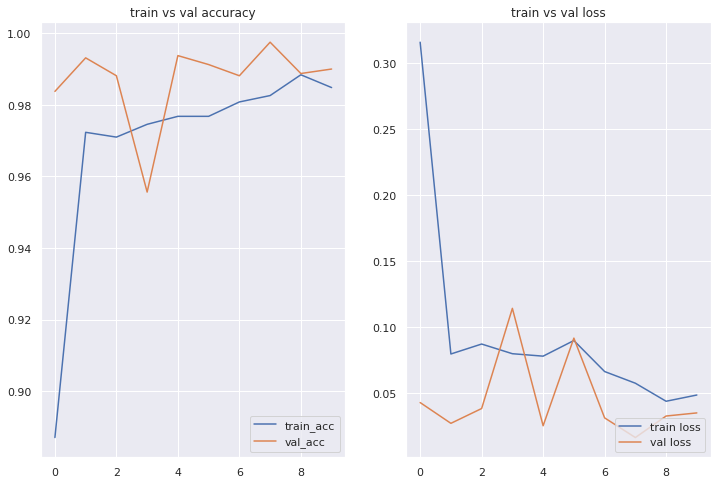

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(10)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend(loc='lower right')
plt.title('train vs val loss')

plt.show()

# 시각화

In [20]:
import cv2
import glob

test_img_list=[]

test_img_name_list=glob.glob('테스트용/*')

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(img_width, img_height))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    test_img_list.append(src_img)

1/1 [==============================] - 0s 24ms/step


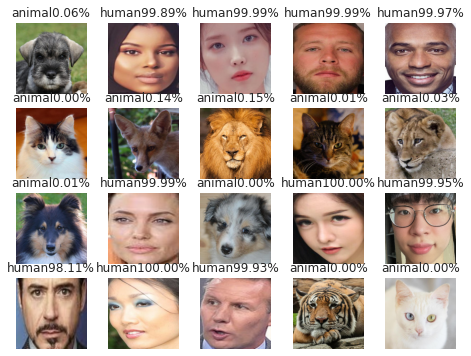

In [32]:
pred=model.predict(np.array(test_img_list))

class_name=['aniaml', 'human']

plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(4,5,i+1)
  prob='{0:0.2f}'.format(100*max(pred[i]))
  if(pred[i]>=0.5):
    title_str='human' + prob+'%'
    plt.title(title_str)

  else:
    title_str='animal' + prob + '%'
    plt.title(title_str)

  plt.imshow(test_img_list[i])
  plt.axis('off')
plt.show()

# 저장된 모델 불러오기

In [26]:
#모델 불러오기
from keras.models import load_model
manORwoman = load_model('/content/이걸로하기man or woman epoch 추가데이터 30, batch=48 teps=70 val=50.h5')

# 인간 vs 동물 and 남자 vs 여자

In [92]:
import cv2
import glob
def resize(img):
  test_img_list=[]
  test_img_name_list=glob.glob(img)

  img = cv2.imread(img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, dsize=(img_width, img_height))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img / 255.0

  test_img_list.append(img)

  # plt.imshow(test_img_list[0])
  # plt.axis('off')
  # print(test_img_list[0].shape)
#def result(img):
  humanORanimal_pred=model.predict(np.array(test_img_list))
  manORwoman_pred=manORwoman.predict(np.array(test_img_list))

  plt.figure(figsize=(6,6))
  # prob='{0:0.2f}'.format(100*max(humanORanimal_pred))
  # prob2='{0:0.2f}'.format(100*max(manORwoman_pred))
  if(humanORanimal_pred>=0.5):
    if(manORwoman_pred>=0.5):
      title_str='human and woman' 
      plt.title(title_str)
    else:
      title_str='human and man'
      plt.title(title_str)

  else:
    title_str='animal'
    plt.title(title_str)

  plt.imshow(img)
  plt.axis('off')
plt.show()
  

1/1 [==============================] - 0s 17ms/step


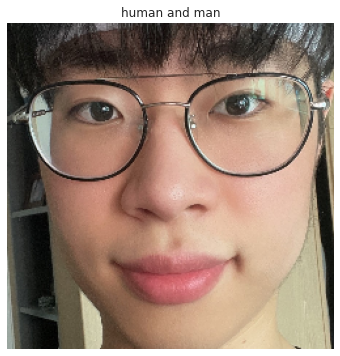

In [93]:
img='테스트용/내사진2.jpg'
save_img=resize(img)
save_img

1/1 [==============================] - 0s 18ms/step


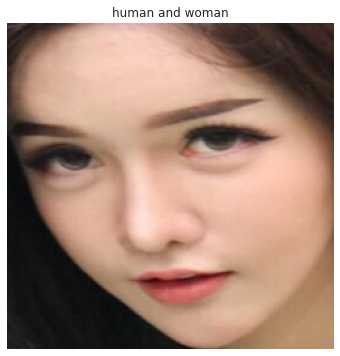

In [99]:
img='테스트용/human3 (1).jpg'
save_img=resize(img)
save_img